# Data Processing for Matminer Data

The purpose of this notebook is to transform the data from the three databases so that they are in the same range and format, in order to be fed into a neural network (NN).

## Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.ndimage import gaussian_filter1d

from PIL import Image
import json
from random import randint

## Upload the data set

In [37]:
df = pd.read_json('matminer.json')

In [38]:
df.head()

,mpid,crystal_system,X_values,Y_values
0,mp-85,Tetragonal,"[32.3536089071, 36.3520663769, 38.1099360092, ...","[100.0, 18.1958586805, 31.8782768858, 22.91688..."
1,mp-110,Cubic,"[35.4679954588, 51.0324956984, 63.6841425788, ...","[100.0, 16.976374379, 33.5918902393, 9.9493066..."
2,mp-20,Cubic,"[51.6585266924, 76.0725042731]","[100.0, 17.5068706603]"
3,mp-8640,Cubic,"[34.6695349659, 40.2473671921, 58.2290835966, ...","[100.0, 49.9874745409, 34.2603160603, 40.33535..."
4,mp-674158,Cubic,"[19.5279458907, 22.5859010533, 32.1552064177, ...","[100.0, 51.0568207953, 37.3581324298, 45.40608..."


In [39]:
df = df.rename(columns = {'X_values': 'X', 'Y_values': 'Y'})

### Convert the XY data to numpy arrays 

In [5]:
df['Y'] = df['Y'].apply(np.array)
df['X'] = df['X'].apply(np.array)

### Delete the materials with no XY data

In [6]:
df['X_size'] = df['X'].apply(lambda x: len(x))
df['Y_size'] = df['Y'].apply(lambda x: len(x))

In [7]:
df.drop(df[df['X_size'] <= 1].index, inplace=True)

In [8]:
df.drop(df[df['Y_size'] <= 1].index, inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df.head()

,mpid,crystal_system,X,Y,X_size,Y_size
0,mp-85,Tetragonal,"[32.3536089071, 36.3520663769, 38.1099360092, ...","[100.0, 18.1958586805, 31.8782768858, 22.91688...",12,12
1,mp-110,Cubic,"[35.4679954588, 51.0324956984, 63.6841425788, ...","[100.0, 16.976374379, 33.5918902393, 9.9493066...",5,5
2,mp-20,Cubic,"[51.6585266924, 76.0725042731]","[100.0, 17.5068706603]",2,2
3,mp-8640,Cubic,"[34.6695349659, 40.2473671921, 58.2290835966, ...","[100.0, 49.9874745409, 34.2603160603, 40.33535...",6,6
4,mp-674158,Cubic,"[19.5279458907, 22.5859010533, 32.1552064177, ...","[100.0, 51.0568207953, 37.3581324298, 45.40608...",19,19


### Find the minimun and maximun of the XY dat

In [11]:
df['X_min'] = df['X'].apply(np.min)
df['X_max'] = df['X'].apply(np.max)
df['Y_min'] = df['Y'].apply(np.min)
df['Y_max'] = df['Y'].apply(np.max)
df[['X_size', 'Y_size','X_min', 'X_max', 'Y_min', 'Y_max']].describe()

,X_size,Y_size,X_min,X_max,Y_min,Y_max
count,83989.000000,83989.000000,83989.000000,83989.000000,83989.000000,83989.0
mean,303.694912,303.694912,13.458542,89.345040,0.247852,100.0
std,421.153713,421.153713,5.508862,1.242603,1.249586,0.0
min,2.000000,2.000000,0.606980,60.181748,0.001000,100.0
25%,55.000000,55.000000,9.712814,89.346162,0.001113,100.0
50%,159.000000,159.000000,12.453733,89.815978,0.001801,100.0
75%,401.000000,401.000000,16.688791,89.948265,0.014391,100.0
max,12060.000000,12060.000000,51.658527,89.999998,47.375530,100.0


In [12]:
df['X_size'] = df['X'].apply(lambda x: len(x))
df['Y_size'] = df['Y'].apply(lambda x: len(x))
df[['X_size', 'Y_size']].describe()

,X_size,Y_size
count,83989.000000,83989.000000
mean,303.694912,303.694912
std,421.153713,421.153713
min,2.000000,2.000000
25%,55.000000,55.000000
50%,159.000000,159.000000
75%,401.000000,401.000000
max,12060.000000,12060.000000


### Renormalize the Y data

In [17]:
df['Y'] = df['Y'].div(df['Y_max']) 

df['Y_min'] = df['Y'].apply(np.min)
df['Y_max'] = df['Y'].apply(np.max)

df[['Y_size', 'Y_min', 'Y_max']].describe()

,Y_size,Y_min,Y_max
count,83989.000000,83989.000000,83989.0
mean,303.694912,0.013745,1.0
std,421.153713,0.014854,0.0
min,2.000000,0.010000,1.0
25%,55.000000,0.010077,1.0
50%,159.000000,0.010273,1.0
75%,401.000000,0.011217,1.0
max,12060.000000,0.473755,1.0


## Delete the False Peaks

Remove the data points of low intensity

In [18]:
def delete_material_false_peaks(material):
    """Removes peaks where Y < 1."""
    mask = material.Y >= 0.01  # Boolean mask for valid values
    return material.X[mask], material.Y[mask]

# Apply the function to each row and update the DataFrame
df[['X', 'Y']] = df.apply(lambda row: pd.Series(delete_material_false_peaks(row)), axis=1)


In [19]:
df[['Y_size', 'Y_min', 'Y_max']].describe()

,Y_size,Y_min,Y_max
count,83989.000000,83989.000000,83989.0
mean,303.694912,0.013745,1.0
std,421.153713,0.014854,0.0
min,2.000000,0.010000,1.0
25%,55.000000,0.010077,1.0
50%,159.000000,0.010273,1.0
75%,401.000000,0.011217,1.0
max,12060.000000,0.473755,1.0


## Data Standardization

Create a common partition for the X interval (X_standard), ensuring that each subinterval has a corresponding Y value. The Y value assigned to each subinterval is taken from an X point that falls within that subinterval. Store the standardized Y data in Y_standard.

In [20]:
start = 0
stop = 90 # The X data represents twice the angle of incidence, measured in degrees.
size = 10000
xstd = np.linspace(start, stop, size)

In [21]:
df['Xstd'] = [xstd] * df.shape[0]

In [22]:
def find_ystd(material):
    xstd = material.Xstd
    x = material.X
    y = material.Y
    
    ystd = np.zeros(xstd.size)
    
    # Make x a matrix by repeating it along rows
    x = np.tile(x, (xstd.size, 1))
    
    # Make xstd a matrix by repeating it along columns and then transposing
    xstd_matrix = np.tile(xstd, (x.shape[1], 1)).T

    # Find the positions of the closest x values in the xstd vector
    diff = np.abs(x - xstd_matrix)
    indx = np.argmin(diff, axis=0)

    # Assign corresponding y values to ystd
    for i in range(indx.size):
        ystd[indx[i]] = y[i]
    
    #change the size of the numbers
    ystd = ystd.astype(np.float16)

    return ystd

In [23]:
df['Ystd'] = df.apply(find_ystd, axis=1)

In [24]:
#Apply a gaussian filter to Ystd
df['Ygau'] = df['Ystd'].apply(lambda y: gaussian_filter1d(np.array(y, dtype=np.float64), sigma=5))

In [28]:
#normalize the Y gaussian data
df['Ygau'] = df['Ygau'].apply(lambda y: (y/np.max(y)).astype(np.float16))

### Verify Standardization

In [40]:
index = 83727
x = df.X.values[index]
y = df.Y.values[index]
#xstd = df.Xstd.values[index]
#ystd = df.Ystd.values[index]
system = df.crystal_system.values[index]

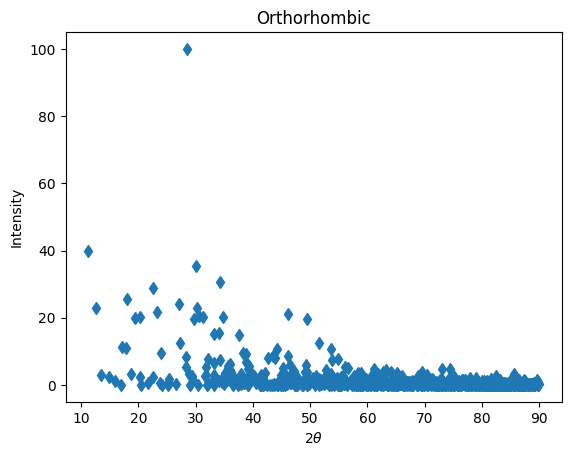

In [41]:

%matplotlib inline
fig, ax = plt.subplots()

ax.plot(x, y, marker='d', linestyle=' ')
ax.set(xlabel='$2θ$', ylabel='Intensity', title=system)
#ax.plot(xstd, ystd, marker='.', linestyle= '--')

plt.show()

In [32]:
df.mpid.values[index]

'mp-601148'

In [38]:
ygau= df.Ygau.values[index]

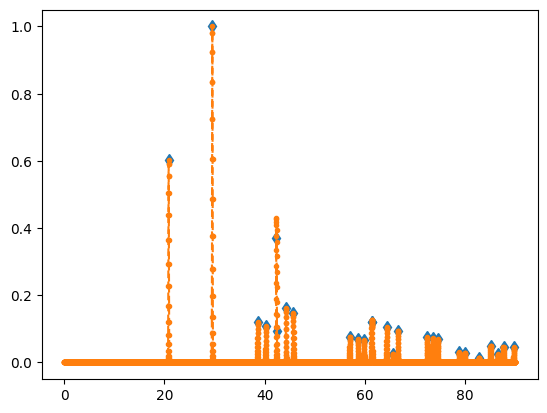

In [39]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(x, y, marker='d', linestyle=' ')
ax.set(xlabel='$2θ$', ylabel='Intensity')
ax.plot(xstd, ygau, marker='.', linestyle= '--')

plt.show()

## Save the data

In [42]:
temp = df[['mpid', 'crystal_system', 'Ygau']]
temp.to_hdf('matminer_gau_cmp.h5','matminerstd', mode='w', complevel=9)

C:\Users\juliana\AppData\Local\Temp\ipykernel_14632\4235327764.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  temp.to_hdf('matminer_gau_cmp.h5','matminerstd', mode='w', complevel=9)
C:\Users\juliana\AppData\Local\Temp\ipykernel_14632\4235327764.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['mpid', 'crystal_system', 'Ygau'], dtype='object')]

  temp.to_hdf('matminer_gau_cmp.h5','matminerstd', mode='w', complevel=9)


In [33]:
df = pd.read_hdf('matminer_gau_cmp.h5','matminerstd')

In [34]:
df.head()

,mpid,crystal_system,Ygau
0,mp-85,Tetragonal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,mp-110,Cubic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,mp-20,Cubic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,mp-8640,Cubic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,mp-674158,Cubic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [35]:
df.loc[73]

mpid                                                      mp-601148
crystal_system                                         Orthorhombic
Ygau              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 73, dtype: object

### Intensity(Y) sample

In [3]:
def plot_data_sample(df, system):
    fig, ax = plt.subplots(figsize=(10, 2))

    crystal_sys = df.groupby('crystal_system')
    
    crystal_sys = crystal_sys.get_group(system).reset_index(drop= True)
    #choose a random material
    np.random.seed(10)
    i = np.random.randint(0, crystal_sys.shape[0])
    material = crystal_sys.loc[i]
    
    img = material.Ygau.reshape((1, -1))
    
    ax.imshow(img, cmap= 'hot', aspect="auto")
    fig.suptitle(system, fontsize=19)
    plt.axis("off")
    plt.show()

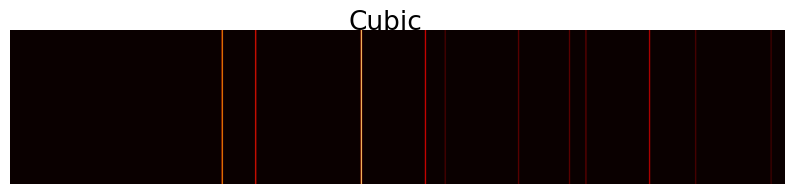

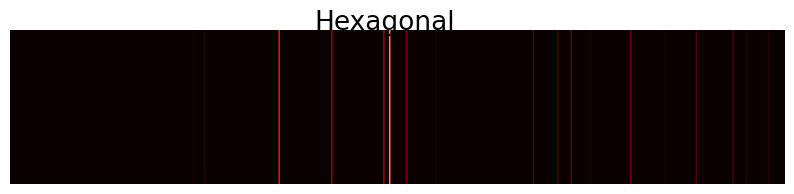

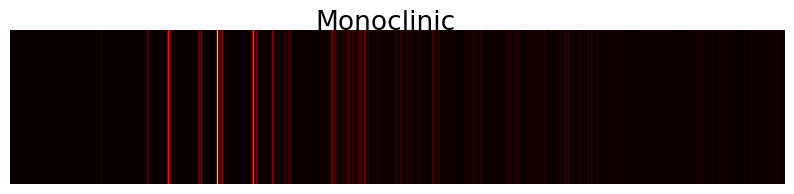

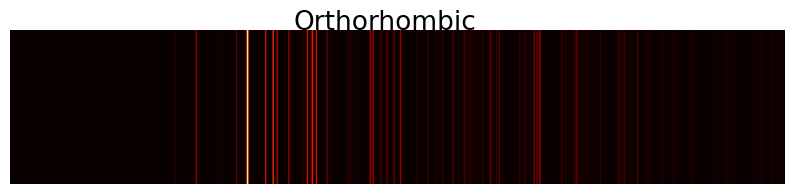

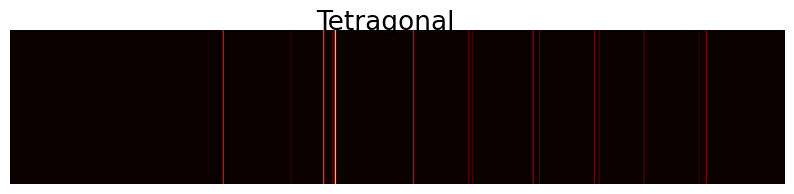

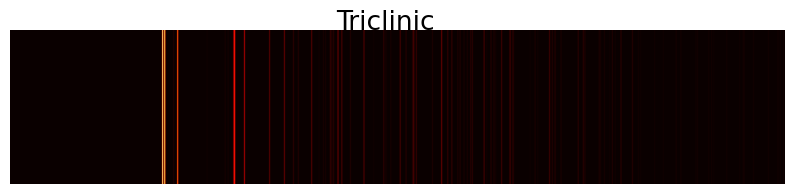

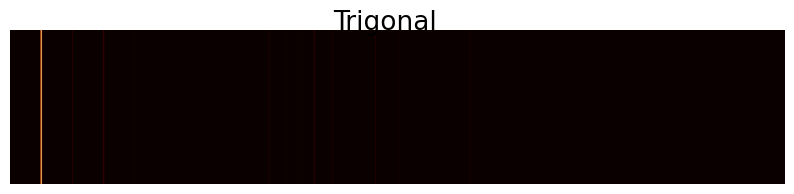

In [4]:
%matplotlib inline
for system in df.groupby('crystal_system').groups.keys():
    plot_data_sample(df, system)

### Sample of the XY plots

In [21]:
def plot_xy_sample(df, system):
    start = 0
    stop = 90 # The X data represents twice the angle of incidence, measured in degrees.
    size = 10000
    xstd = np.linspace(start, stop, size)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    crystal_sys = df.groupby('crystal_system')
    
    crystal_sys = crystal_sys.get_group(system).reset_index(drop= True)
    #choose a random material
    np.random.seed(10)
    i = np.random.randint(0, crystal_sys.shape[0])
    material = crystal_sys.loc[i]
    
    ax.plot(xstd, material.Ygau)
    ax.set(title=system, xlabel='$2θ$', ylabel='Intensity')
    plt.savefig('fig.jpg')
    plt.show()

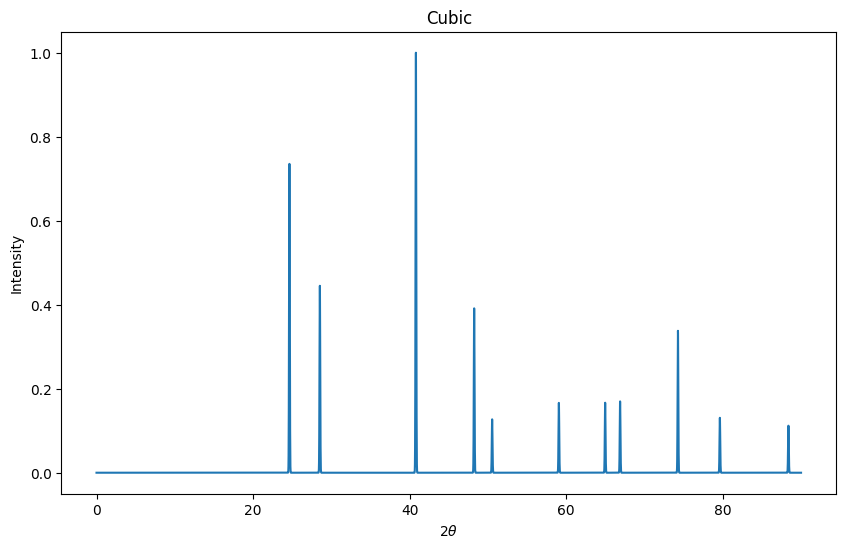

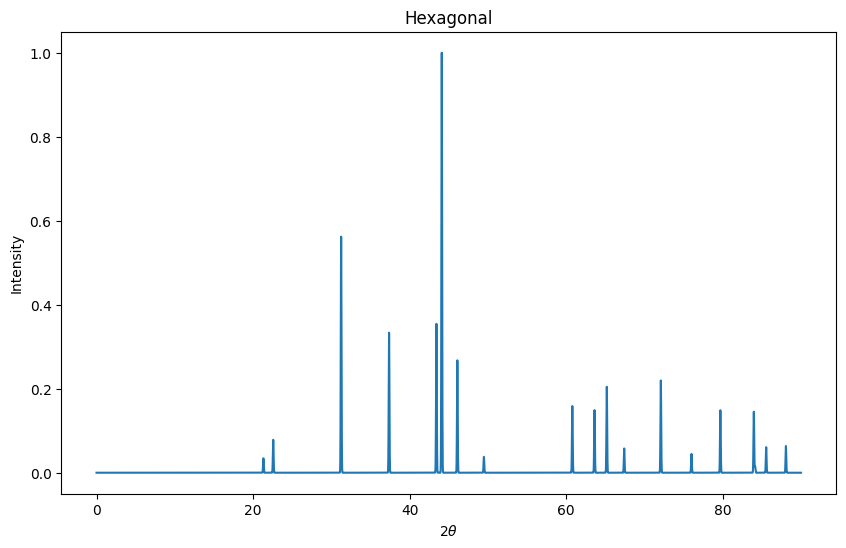

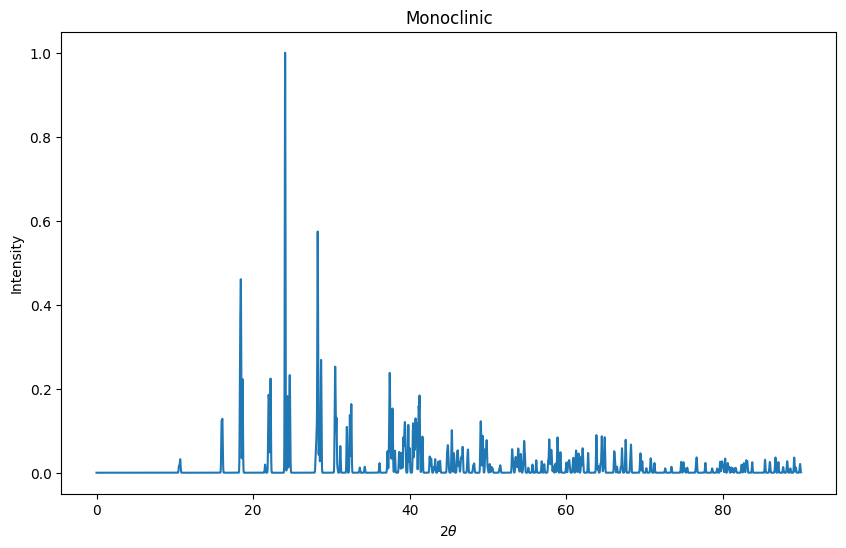

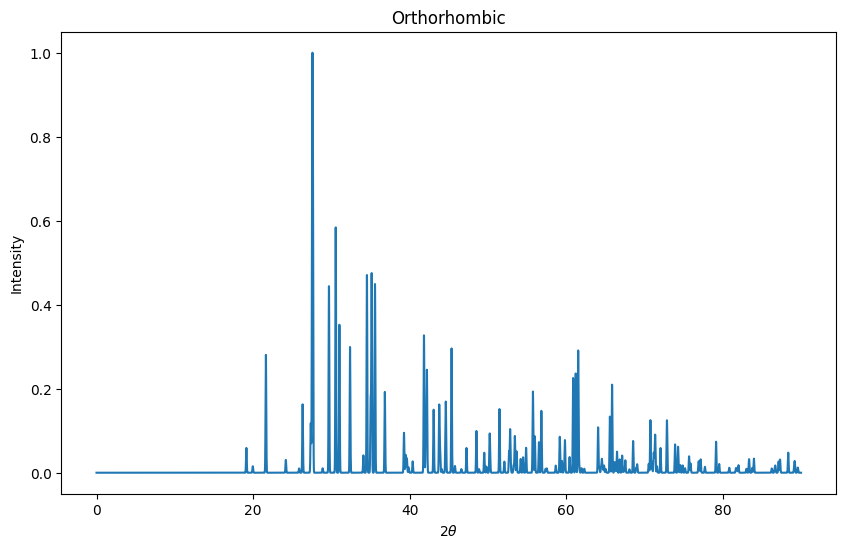

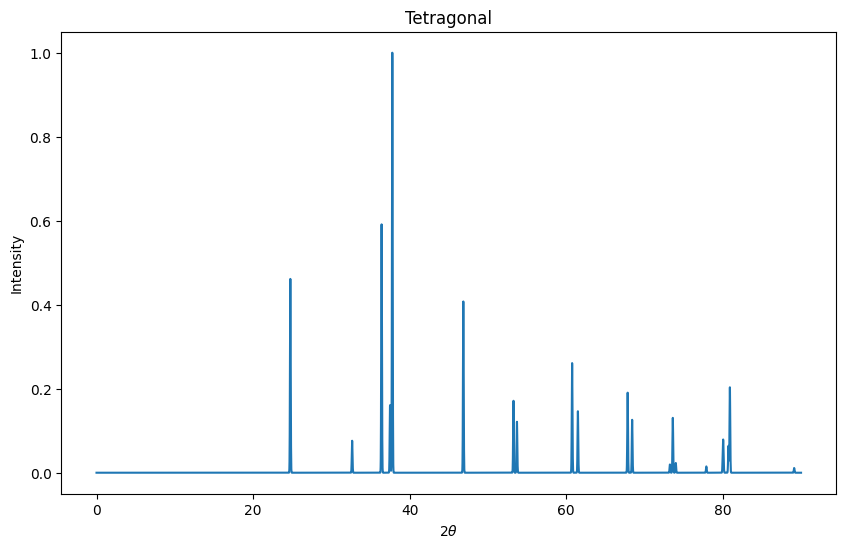

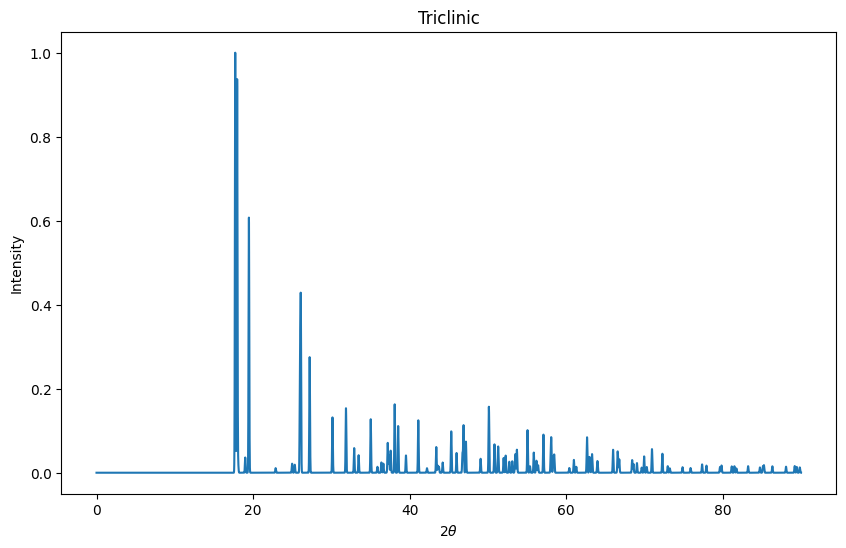

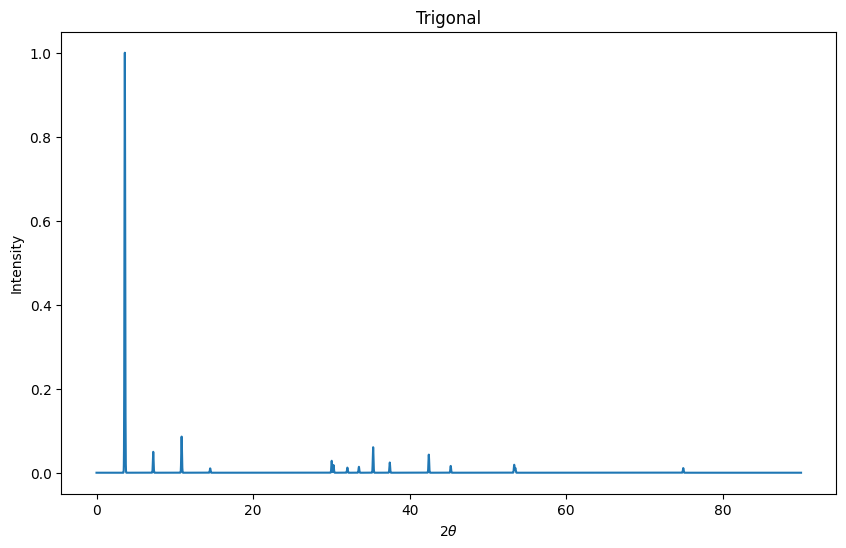

In [10]:
for system in df.groupby('crystal_system').groups.keys():
    plot_xy_sample(df, system)

<Figure size 640x480 with 0 Axes>

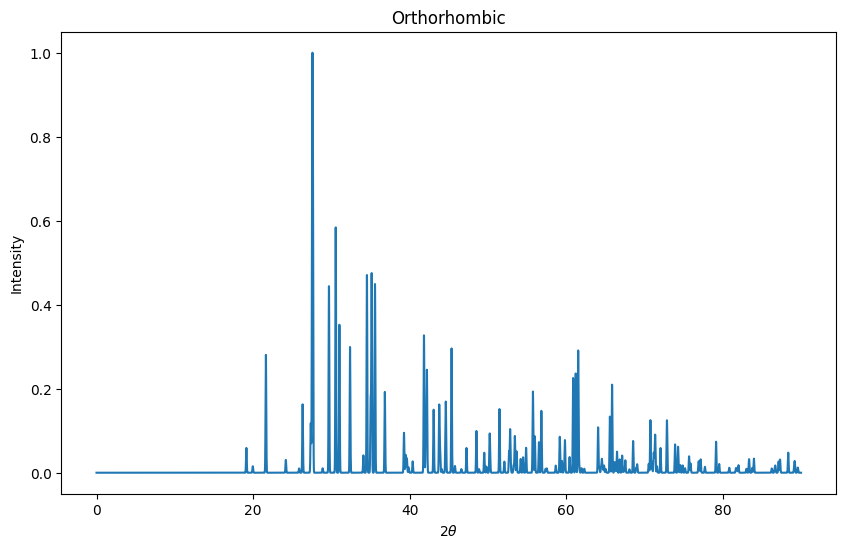

In [22]:
%matplotlib inline
plot_xy_sample(df, 'Orthorhombic')